In [188]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [100]:
# Camera calibration
def calibrate_camera(images, draw_corners=None):
    '''
    Calibarate the camera with a list of images
    
    Params:
    images: a list of images taken by the camera, used to calibrate the camera
    draw_corners: if true, draw the found corners on the image
    
    Return: camera matrix, distortion coefficient
    '''
    # Two lists to store object points and image points
    objpoints = []
    imgpoints = []
    
    # Prepare object points
    objp = np.zeros([6*9, 3], np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    # Step through each image
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
        
        # If found corners, add the image points and correponding object points
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # If needed, draw the corners on the image
            if draw_corners == True:
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img) 
    
    # Calibrate camera with object points and image points
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return mtx, dist   

In [105]:
# Calibrate the camera with calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(images)

In [139]:
# Detect lane lines with gradients thresholds and color thresholds
def detect_laneline(img, grad_mag_thresh=(30, 100), grad_dir_thresh=(np.pi/4, np.pi/2), 
                color_threshold=(0,255), color_channel='L'):
    '''
    Detect lane line with both gradients filter and color filters
    
    Params:
    img: an undistorted image
    grad
    
    Return: a binary file with visible lane lines
    '''
    
    # First, get the gradient filter
    # Convert color image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradient with Sobel
    sobelx64f = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely64f = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate gradient magnitude and convert to uint8
    grad_mag64f = np.sqrt(sobelx64f**2 + sobely64f**2)
    grad_mag = np.uint8(grad_mag64f*255/np.max(grad_mag64f))
    
    # Calculate gradient direction
    grad_dir_value = np.abs(sobely64f/sobelx64f)
    grad_dir = np.arctan(grad_dir_value)
    
    # Get gradient filter mask
    mask_grad = (grad_mag>grad_mag_thresh[0])&(grad_mag<grad_mag_thresh[1])\
           &(grad_dir>grad_dir_thresh[0])&(grad_dir<grad_dir_thresh[1])
   
    
    # Second, get the color filter 
    #Convert the image to HLS and split channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L, S = hls[:,:,1], hls[:,:,2]
    
    # Get color filter mask
    if color_channel == 'L':
        channel = np.copy(L)
    elif color_channel == 'S':
        channel = np.copy(S)    
    mask_color = (channel>color_threshold[0])&(channel<color_threshold[1])
    
    # Apply both masks
    binary = np.zeros_like(gray)
    binary[mask_grad&mask_color]=1
    
    return binary

In [272]:
# Perspective transform
def transform_perspective(img):
    h, w = img.shape[0], img.shape[1]
    
     # Four source points
    src = np.float32(
          [[215, 705],
          [604, 442],
          [675, 442],
          [1098, 705]])

    # Four destination points
    dst = np.float32(
         [[300, 720],
          [300, 0],
          [1000, 0],
          [1000, 720]])

    # Compute transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped

In [ ]:
%matplotlib qt

plt.imshow(undist)

# Four source points
src = np.float32(
     [[215, 705],
      [604, 442],
      [675, 442],
      [1098, 705]])

# Four destination points
dst = np.float32(
     [[300, 720],
      [300, 0],
      [1000, 0],
      [1000, 720]])
plt.plot((src[0,0], src[1,0]), (src[0,1], src[1,1]), 'r-')
plt.plot((src[2,0], src[3,0]), (src[2,1], src[3,1]), 'r-')

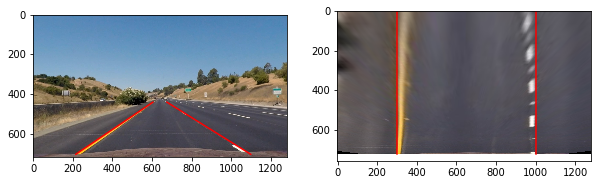

In [271]:
%matplotlib inline

warped = transform_perspective(undist)

fig = plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(undist)
plt.plot((src[0,0], src[1,0]), (src[0,1], src[1,1]), 'r-')
plt.plot((src[2,0], src[3,0]), (src[2,1], src[3,1]), 'r-')

plt.subplot(122), plt.imshow(warped)
plt.plot((dst[0,0], dst[1,0]), (dst[0,1], dst[1,1]), 'r-')
plt.plot((dst[2,0], dst[3,0]), (dst[2,1], dst[3,1]), 'r-')

In [133]:
# Find the lines
def find_line(img):
    return None

In [134]:
# Calculate curvature and position
def calculate_curvature(img):
    return None

/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


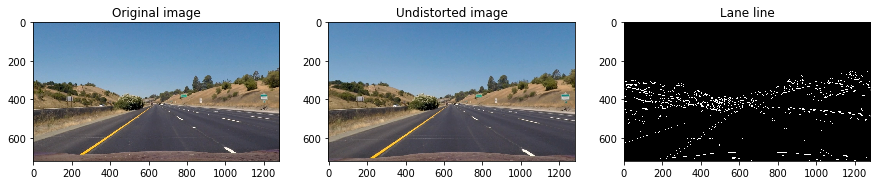

In [145]:
# Test the undistortion function
fl = './test_images/straight_lines1.jpg'
img = mpimg.imread(fl)
undist = cv2.undistort(img, mtx, dist, None, mtx)

fig = plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title('Original image')
plt.subplot(122), plt.imshow(undist)
plt.title('Undistorted image')


/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/yuetingliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


(<matplotlib.axes._subplots.AxesSubplot at 0x14c654198>,
 <matplotlib.text.Text at 0x14a6837f0>)

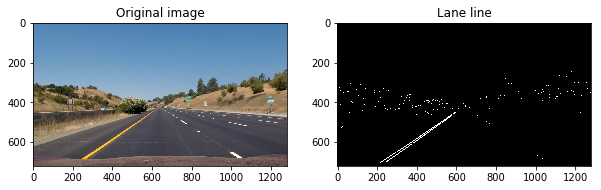

In [273]:
# Test detect_laneline function
grad_mag_thresh=(30, 200)
grad_dir_thresh=(np.pi/4, np.pi/3)
color_threshold=(50,255)
color_channel='S'
binary = detect_laneline(undist, grad_mag_thresh, grad_dir_thresh, color_threshold, color_channel)

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title('Original image')
plt.subplot(122), plt.imshow(binary, cmap='gray'), plt.title('Lane line')